# The Digital Detective: Finding Fraud with SOMs

**Objective**: Learn how to use **Self-Organizing Maps (SOM)** for Anomaly Detection.

## The Scenario
You are the Chief Security Officer at a futuristic bank. Hackers are getting smarter, and simple rules like "no transactions over $10,000" don't catch the subtle thieves anymore.

You have a massive stream of transaction data, but **you don't know which ones are fraud**. You only know what "Normal" looks like. 

**The Tool**: A Self-Organizing Map (SOM). It's an unsupervised neural network that takes complex, high-dimensional data and maps it onto a simple 2D grid. 

- **Normal transactions** will clump together in safe zones.
- **Fraud** will stand out as weird, lonely points on the map.

Let's build a fraud detector!

In [1]:
# 1. Import The Toolbelt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 2. Generate "Transaction Data"

We will create a synthetic dataset representing credit card usage.
- **Features**: `Amount`, `Distance from Home`, `Transaction Frequency`.
- **Normal Behavior**: People usually buy coffee near home (Cluster 1) or groceries slightly further away (Cluster 2).
- **Fraud**: Random, sporadic, high-value, or far-away transactions.

In [2]:
# Generate 500 "Normal" Transactions (2 main clusters)
X_normal, _ = make_blobs(n_samples=500, centers=2, cluster_std=0.8, n_features=3, random_state=42)

# Generate 20 "Fraudulent" Transactions (Explicit Outliers)
# Place them far away from the normal clusters
np.random.seed(42)
X_fraud = np.array([
    [8.0, 8.0, 8.0], [9.0, 9.0, 9.0], [7.0, 7.0, 7.0], [10.0, 10.0, 10.0], [6.0, 6.0, 6.0], 
    [-8.0, -8.0, -8.0], [-9.0, -9.0, -9.0], [-7.0, -7.0, -7.0], [-10.0, -10.0, -10.0], [-6.0, -6.0, -6.0],
    [5.0, -5.0, 5.0], [-5.0, 5.0, -5.0], [6.0, -6.0, 6.0], [-6.0, 6.0, -6.0], [4.0, -4.0, 4.0],
    [9.0, -9.0, 9.0], [-9.0, 9.0, -9.0], [8.0, -8.0, 8.0], [-8.0, 8.0, -8.0], [7.0, -7.0, 7.0]
]) 
# Add noise
X_fraud += np.random.normal(0, 0.2, size=X_fraud.shape)

# Combine them
X = np.vstack([X_normal, X_fraud])
print(f"Total Transactions: {len(X)}")
print(f"Normal: 500, Fraud: 20 (Explicit Outliers)")

# Normalize Data (Crucial for SOMs!)
# SOM uses Euclidean distance, so if 'Amount' is 1000 and 'Time' is 1, Amount dominates.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Total Transactions: 520
Normal: 500, Fraud: 20 (Explicit Outliers)


# 3. Building a SOM from Scratch

Since standard libraries like `sklearn` don't have SOMs, we will build a simple one to understand the magic.

**How it works**:
1.  **The Grid**: We create a grid of neurons (e.g., 10x10).
2.  **Competition**: For every transaction, we find the "Winning Neuron" (closest match).
3.  **Cooperation**: The winner *and its neighbors* update their weights to look more like the transaction.
4.  **Result**: The grid folds itself to fit the shape of the data.

In [3]:
class SimpleSOM:
    def __init__(self, x, y, input_len):
        self.x = x
        self.y = y
        self.input_len = input_len
        # Initialize weights randomly
        self.weights = np.random.random((x, y, input_len))
        self.learning_rate = 0.5
        self.radius = max(x, y) / 2
        # time_constant will be set in train()

    def find_winner(self, sample):
        # Calculate Euclidean distance between sample and all weights
        # This creates a map of distances
        diff = self.weights - sample
        sq_dist = np.sum(diff**2, axis=2)
        # Find the index of the minimum distance
        # unravel_index converts the flat index back to (x, y) coordinates
        return np.unravel_index(np.argmin(sq_dist), (self.x, self.y))

    def update_weights(self, sample, winner, iteration):
        # Decay learning rate and radius over time
        # rad decays from initial_radius to 1
        rad = self.radius * np.exp(-iteration / self.time_constant)
        # learning rate also decays
        lr = self.learning_rate * np.exp(-iteration / self.time_constant)
        
        # Avoid division by zero issues
        if rad < 1e-10:
            rad = 1e-10

        # Loop through all neurons 
        for i in range(self.x):
            for j in range(self.y):
                # Calculate distance to the winning neuron in the GRID (not data space)
                dist_to_winner = np.sqrt((i - winner[0])**2 + (j - winner[1])**2)
                
                # If inside the neighborhood radius, update weight
                if dist_to_winner <= rad:
                    # Influence drops off with distance (Gaussian neighborhood)
                    influence = np.exp(-(dist_to_winner**2) / (2 * (rad**2)))
                    
                    # The learning rule: New = Old + (LR * Influence * (Data - Old))
                    self.weights[i, j] += lr * influence * (sample - self.weights[i, j])

    def train(self, data, num_epochs):
        total_steps = len(data) * num_epochs
        # Determine time_constant so that radius decays to 1 at the end of training
        self.time_constant = total_steps / np.log(self.radius)
        
        step = 0
        for epoch in range(num_epochs):
            # Shuffle data for randomness
            np.random.shuffle(data)
            for sample in data:
                winner = self.find_winner(sample)
                self.update_weights(sample, winner, step)
                step += 1
            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} complete.")
                
    # Compute Distance Map (U-Matrix) for visualization
    def distance_map(self):
        # Create a map where each value is the mean distance to neighbors
        dmap = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                # Collect valid neighbors
                neighbors = []
                if i > 0: neighbors.append(self.weights[i-1, j])
                if i < self.x-1: neighbors.append(self.weights[i+1, j])
                if j > 0: neighbors.append(self.weights[i, j-1])
                if j < self.y-1: neighbors.append(self.weights[i, j+1])
                
                # Average distance to neighbors
                dists = [np.linalg.norm(self.weights[i, j] - n) for n in neighbors]
                dmap[i, j] = np.mean(dists)
        
        # Normalize to 0-1 for plotting
        if dmap.max() == dmap.min(): return dmap
        return (dmap - dmap.min()) / (dmap.max() - dmap.min())

print("SOM Class defined! Ready to train.")

SOM Class defined! Ready to train.


# 4. Training the Detective

We will initialize a 10x10 SOM. That's 100 neurons trying to learn the shape of our credit card data.

In [4]:
# 10x10 grid, 3 input features
som = SimpleSOM(10, 10, 3)

print("Training... (This might take a moment)")
som.train(X_scaled, num_epochs=100)
print("Training Complete!")

Training... (This might take a moment)


Epoch 10/100 complete.

Epoch 20/100 complete.
Epoch 30/100 complete.


Epoch 40/100 complete.


Epoch 50/100 complete.
Epoch 60/100 complete.


Epoch 70/100 complete.


Epoch 80/100 complete.
Epoch 90/100 complete.


Epoch 100/100 complete.
Training Complete!


# 5. The Fraud Map (Visualizing Outliers)

Now we calculate use the U-Matrix (Unified Distance Matrix). 

- **Dark Blue**: Neurons that are close to each other. These represent dense, "Normal" clusters.
- **Bright/White**: Neurons that are far from neighbors. These are the "Walls" or potentially outliers.

We will plot our actual data points on top.
- If a transaction lands on a "Winning Neuron" that is isolated or far away, it is suspicious.

Generating Map...


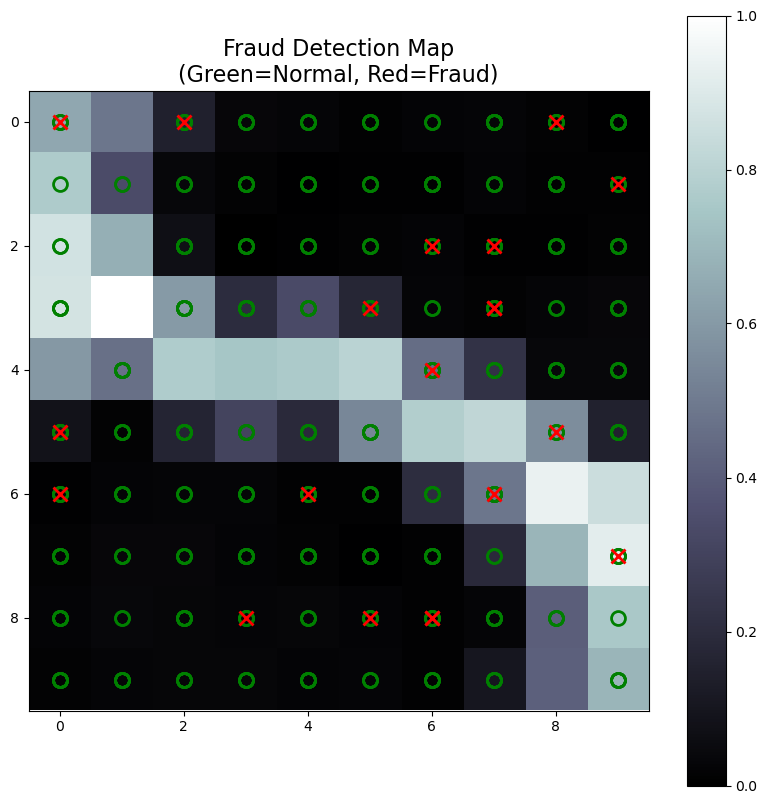

In [5]:
from pylab import bone, pcolor, colorbar, plot, show
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

print("Generating Map...")
# 1. Plot the Distance Map background
# We use imshow for a simple pixel-based heatmap. 
# scaling = 'none' ensures clean pixels without smoothing.
# cmap='bone' for the dark theme.
dmap = som.distance_map()
plt.imshow(dmap, cmap='bone', interpolation='none')
plt.colorbar()

# 2. Mark the winning neurons
markers = ['o', 'x']
colors = ['g', 'r']

for i, x in enumerate(X_scaled):
    w = som.find_winner(x)
    # w = (row, col)
    # imshow displays matrix as (row=Y, col=X) by default (with origin at top-left)
    # So we plot x=col, y=row.
    is_fraud = 1 if i >= 500 else 0
    
    plt.plot(w[1],          # x axis = column index
             w[0],          # y axis = row index
             markers[is_fraud],
             markeredgecolor=colors[is_fraud],
             markerfacecolor='None',
             markersize=10,
             markeredgewidth=2)

plt.title('Fraud Detection Map\n(Green=Normal, Red=Fraud)', fontsize=16)
plt.show()

## Conclusion / Insight

Look at the map above:
1.  **Green Circles (Normal)**: They should be clumped together in the dark regions.
2.  **Red Crosses (Fraud)**: They should often land in different spots, sometimes in the lighter areas (high distance from norms).

**Cyber Security Value**: In a real bank, we would flag any new transaction that maps to a "White" (high distance) cell or a cell that has never had a Green circle before.